In [1]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

In [2]:
#коннект к базе данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250220'
}

Прогнозирование пользовательской активности.

Задача:
В последнее время в приложении наблюдаются жалобы на подвисания. Это может быть связано с ростом активности пользователей и, как следствие, увеличением нагрузки на серверы. Чтобы спрогнозировать потенциальные пики активности и помочь инженерной команде подготовиться, требуется оценить поведение пользователей на ближайший месяц с помощью модели временных рядов.

Цель:
Построить модель прогнозирования пользовательской активности, определить возможную нагрузку и интерпретировать результаты для принятия управленческих решений.

Вопрос 1. Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?

Я планирую прогнозировать метрику "количество просмотров", так как она напрямую влияет на нагрузку на сервер.Например, DAU бы рассматривал только уникальных пользователей, но один пользователь может зайти много раз в приложение и тем самым нагрузка на сервер увеличиться, и по DAU мы это отследить не сможем.
Я отобразила все данные,что имеются,для того чтобы посмотреть какой есть диапазон временной. На графике ниже видно,что вначале запуска просмотров не так много, но в дальнейшем их количество увеличилось. Если взять временной промежуток с 01.01.2025, я думаю это может запутать прогноз. К тому же я проверила и увидела,что метрики с диапазоном от 01.01.2025 правда хуже.
Прогноз нужно сделать на 30 дней вперед,поэтому данных от 30 дней имеющихся может быть достаточно. Я решила взять диапазон от 01.02.2025 до 15.03.2025.
В качестве регрессора я беру DAU, потому что количество активных пользователей может повлиять на количество просмотров. Также данные по наличию флешмоба,ведь на графике я увидела,что он спровоцировал увеличение просмотров.

<Axes: xlabel='hour_time', ylabel='views'>

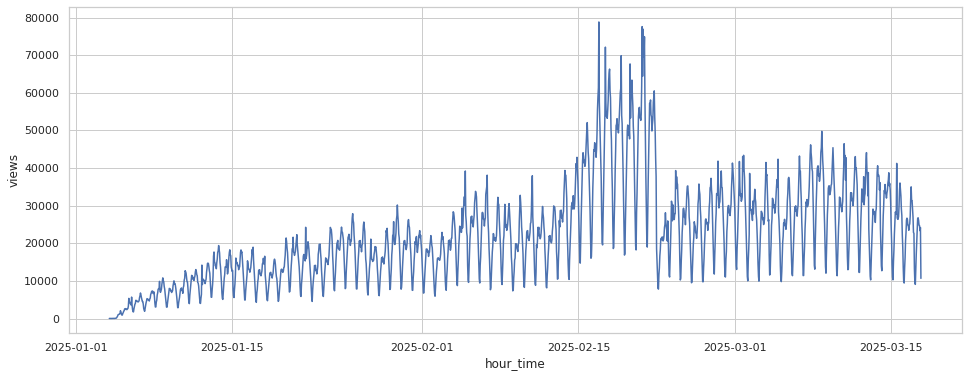

In [309]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
     sum(action = 'view') as views
FROM 
    {db}.feed_actions
GROUP BY hour_time
ORDER BY 
    hour_time
'''
all_views = ph.read_clickhouse(query=query, connection=connection)
#зададим рисовательный шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")
sns.lineplot(x="hour_time", y="views", data=all_views)

Беру выбранный временной промежуток

In [170]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
     sum(action = 'view') as views
FROM 
    {db}.feed_actions
WHERE hour_time >= toDateTime('2025-02-01')
  AND hour_time <= toDateTime('2025-03-15')
GROUP BY hour_time
ORDER BY 
    hour_time
'''

In [171]:
activity = ph.read_clickhouse(query=query, connection=connection)
activity

,hour_time,views
0,2025-02-01 00:00:00,15597
1,2025-02-01 01:00:00,12983
2,2025-02-01 02:00:00,9500
3,2025-02-01 03:00:00,6751
4,2025-02-01 04:00:00,6819
...,...,...
1004,2025-03-14 20:00:00,35281
1005,2025-03-14 21:00:00,35896
1006,2025-03-14 22:00:00,34214
1007,2025-03-14 23:00:00,30708


<Axes: xlabel='hour_time', ylabel='views'>

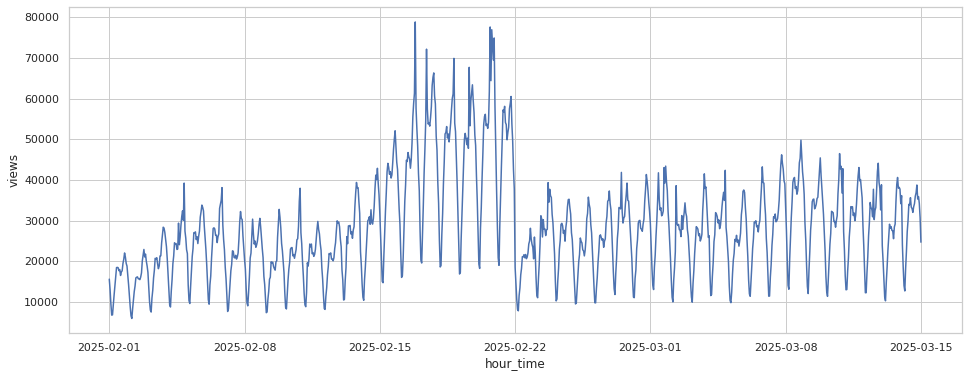

In [310]:

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")
sns.lineplot(x="hour_time", y="views", data=activity)

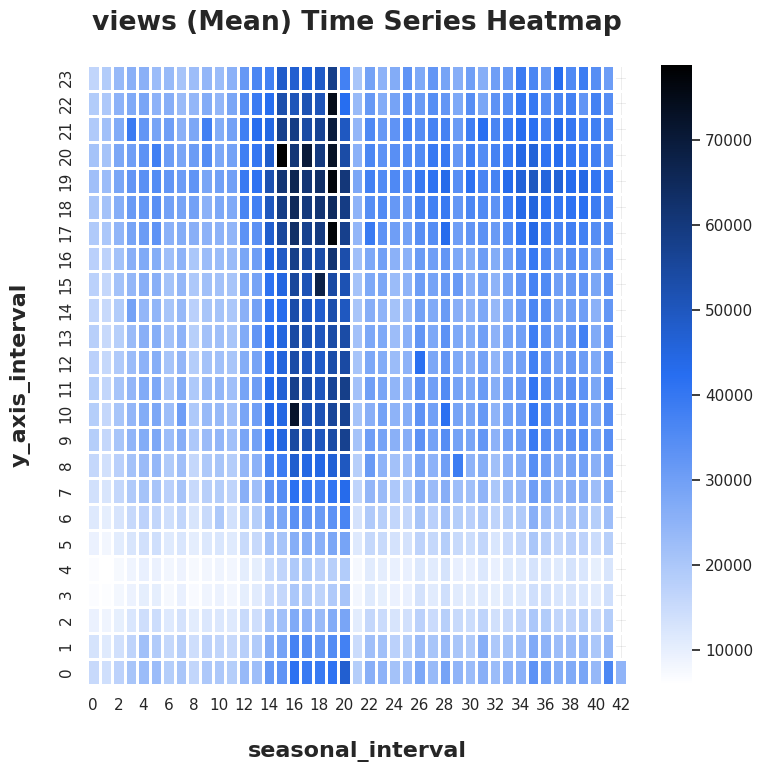

In [173]:
#эксплораторные штуки
from orbit.eda import eda_plot
#тепловая карта
_ = eda_plot.ts_heatmap(df=activity, date_col="hour_time", value_col="views", seasonal_interval=24, normalization=False)

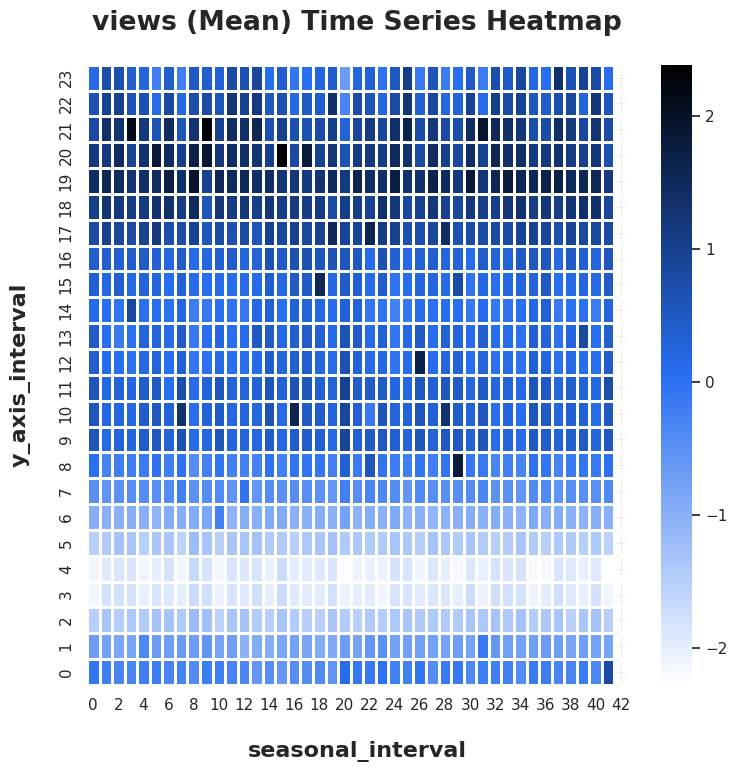

In [174]:
#нормализированный вариант
_ = eda_plot.ts_heatmap(df=activity, date_col="hour_time", value_col="views", seasonal_interval=24, normalization=True)

Вопрос 2. Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.

Строим модель stan-map

In [175]:
dlt = DLT(response_col="views", #название колонки с метрикой
          date_col="hour_time", #название колонки с датами-временем
          seasonality=24, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервал

2025-03-17 12:55:07 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [176]:
dlt.fit(activity)

Датафрейм с горизонтом прогнозирования на 30 дней

In [177]:
future_df = dlt.make_future_df(periods=24*30) #горизонт будет 7 дней - то есть 7 раз по 24 часа
future_df.head()

,hour_time
0,2025-03-15 01:00:00
1,2025-03-15 02:00:00
2,2025-03-15 03:00:00
3,2025-03-15 04:00:00
4,2025-03-15 05:00:00


In [178]:
predicted_df = dlt.predict(df=future_df)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95
0,2025-03-15 01:00:00,13944.651007,18606.914018,23825.808248
1,2025-03-15 02:00:00,8075.940538,13060.954796,18251.988423
2,2025-03-15 03:00:00,3078.800382,8492.125573,13789.756315
3,2025-03-15 04:00:00,1638.089235,7174.696351,12675.637720
4,2025-03-15 05:00:00,7340.208819,12443.167129,17757.069075


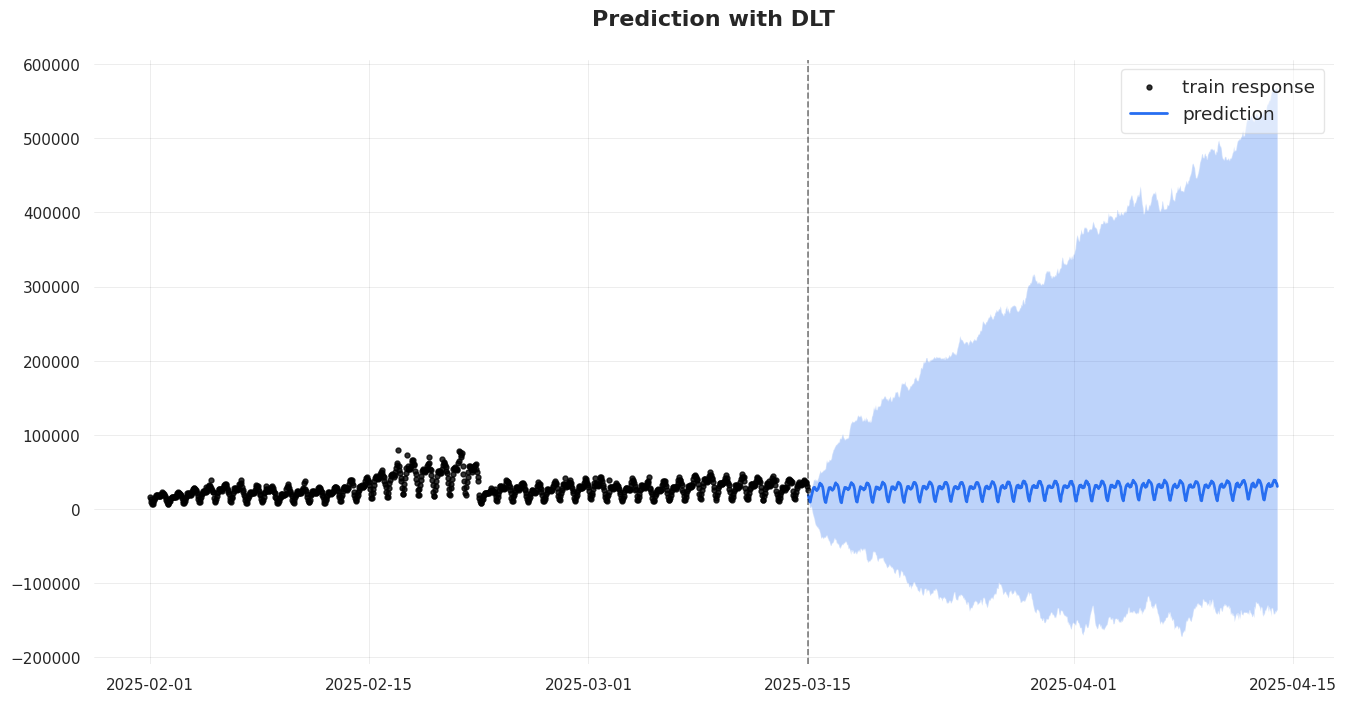

In [185]:
_ = plot_predicted_data(activity, predicted_df, "hour_time", 'views', title='Prediction with DLT')

Декомпозиция предсказания

In [180]:
predicted_df = dlt.predict(df=future_df, 
                           decompose=True) 
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-03-15 01:00:00,13223.349093,18606.914018,23708.723820,17517.919093,22901.484018,28003.293820,-4294.57,-4294.57,-4294.57,0.0,0.0,0.0
1,2025-03-15 02:00:00,8277.985056,13060.954796,18458.424379,18118.485056,22901.454796,28298.924379,-9840.50,-9840.50,-9840.50,0.0,0.0,0.0
2,2025-03-15 03:00:00,3244.649924,8492.125573,13539.500454,17653.949924,22901.425573,27948.800454,-14409.30,-14409.30,-14409.30,0.0,0.0,0.0
3,2025-03-15 04:00:00,1629.074505,7174.696351,12825.721195,17355.774505,22901.396351,28552.421195,-15726.70,-15726.70,-15726.70,0.0,0.0,0.0
4,2025-03-15 05:00:00,7482.946230,12443.167129,17759.010608,17941.146230,22901.367129,28217.210608,-10458.20,-10458.20,-10458.20,0.0,0.0,0.0


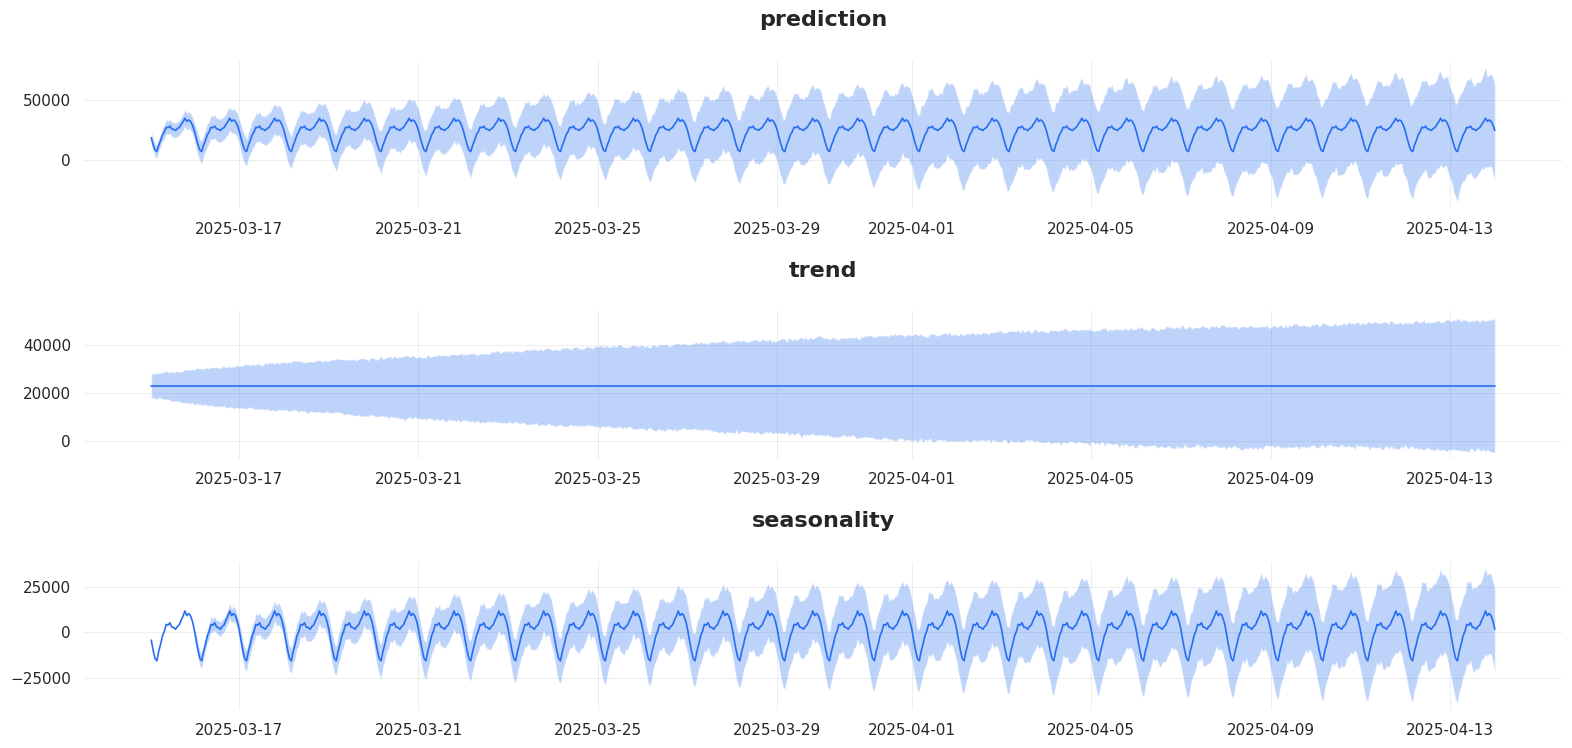

In [181]:
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

Строим модель MCMC

In [347]:
dlt_mcmc = DLT(seasonality=24, response_col="views", date_col="hour_time", 
               estimator='stan-mcmc', #новый алгоритм оценки
               num_warmup=3000, #время "разогрева"
               num_sample=1000) #время сэмплирования

In [348]:
dlt_mcmc.fit(activity)

2025-03-17 14:29:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1250 and samples(per chain): 750.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1250 and samples(per chain): 750.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

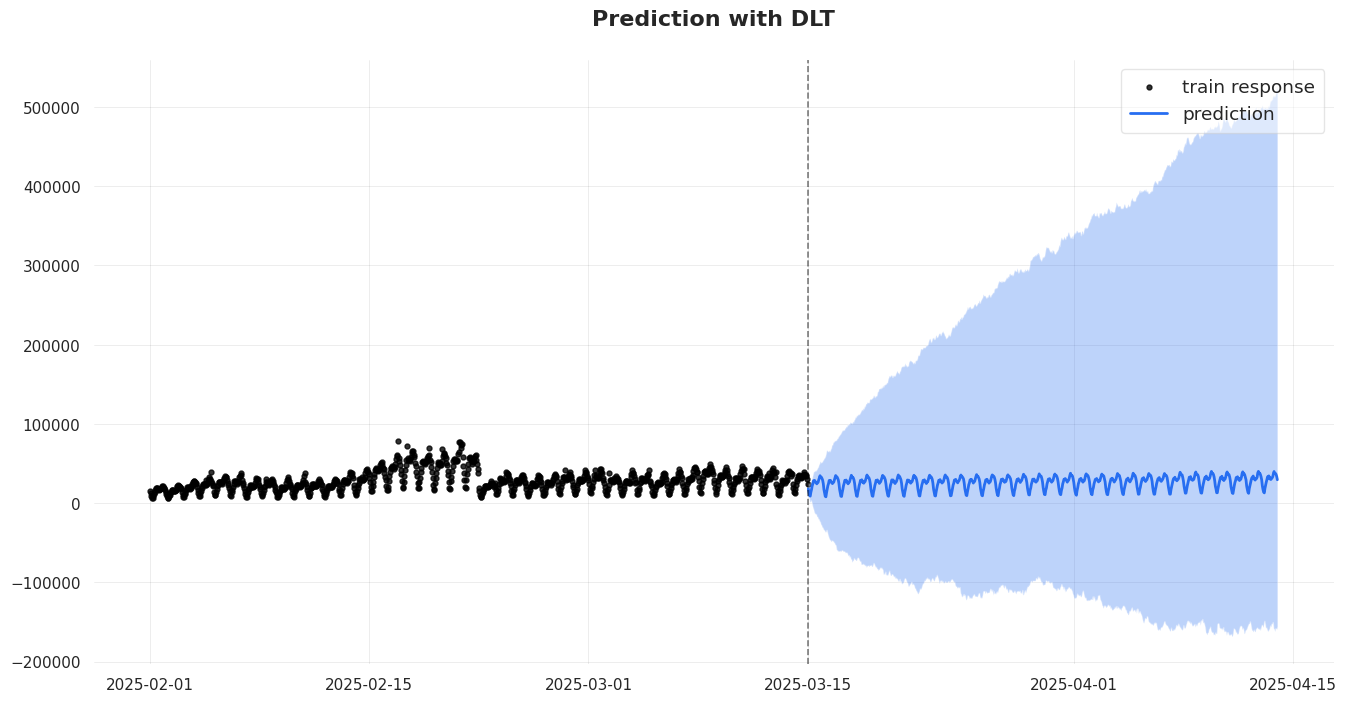

In [349]:
future_df = dlt_mcmc.make_future_df(periods=24*30)#тот же горизонт прогнозирования

predicted_df = dlt_mcmc.predict(df=future_df)

_ = plot_predicted_data(activity, predicted_df, "hour_time", 'views', title='Prediction with DLT')

In [350]:
#декомпозиция цепей
predicted_df = dlt_mcmc.predict(df=future_df, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-03-15 01:00:00,12216.425604,18250.645176,24395.071609,17694.476989,23592.140639,29845.942029,-10543.610,-6283.865,-521.26415,0.0,0.0,0.0
1,2025-03-15 02:00:00,7160.569118,13525.146487,22598.713701,14014.873425,23165.517587,30458.253180,-14749.855,-10869.150,-990.58710,0.0,0.0,0.0
2,2025-03-15 03:00:00,2670.014482,9508.889718,23120.924690,9159.185535,23368.669942,30870.042430,-18615.000,-14853.250,-434.45365,0.0,0.0,0.0
3,2025-03-15 04:00:00,1268.016003,8792.261974,24695.130305,5181.956298,23214.462009,31751.210107,-19148.250,-15327.800,1463.87600,0.0,0.0,0.0
4,2025-03-15 05:00:00,3439.295188,13878.663090,27757.871033,1048.784836,23105.298452,32530.723902,-13477.800,-9659.840,3784.80800,0.0,0.0,0.0


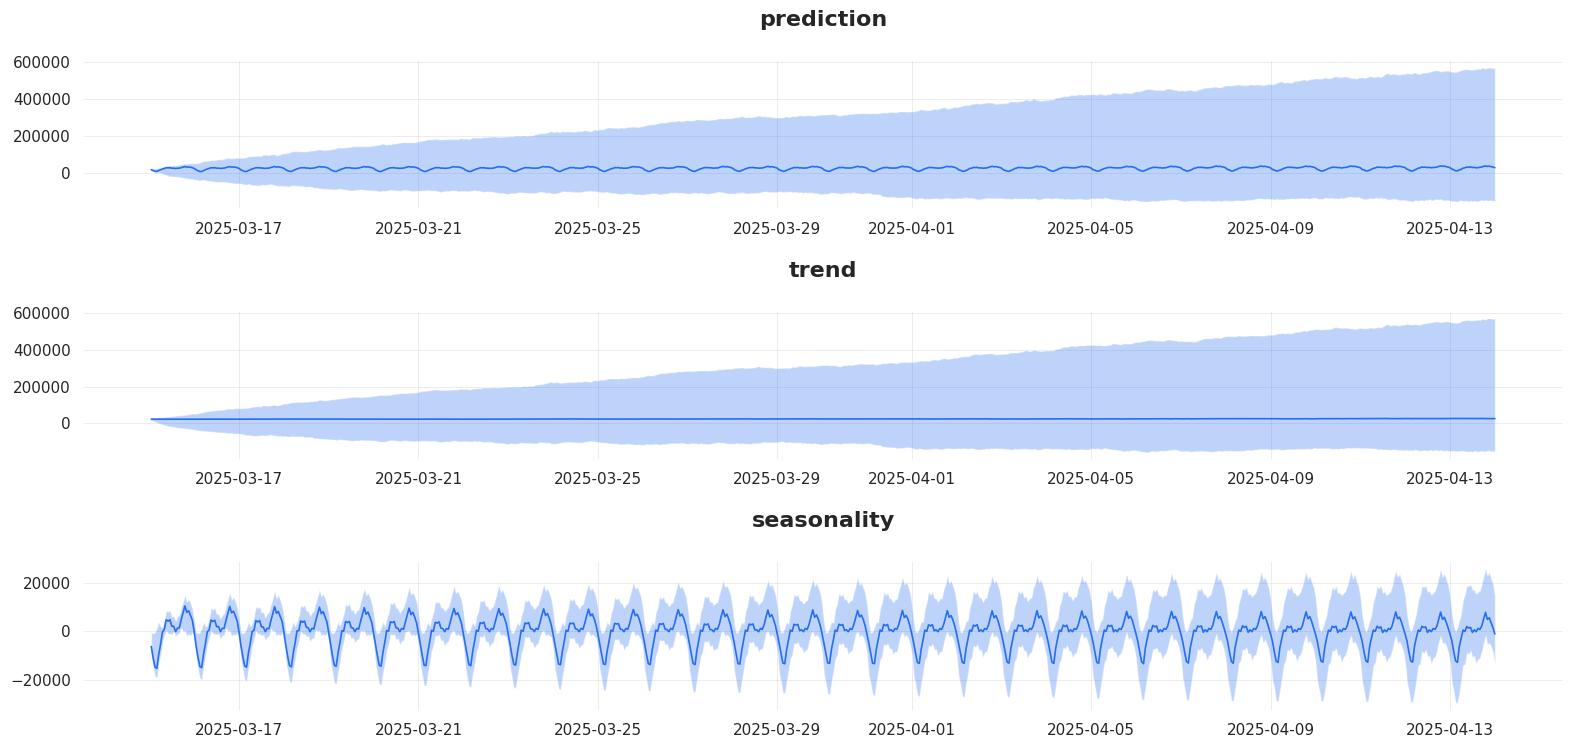

In [351]:
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

Проверка качества моделей через бекстинг.
Горизонт прогнозирования-30 дней, для этого на обучение у нас не хватает данных(я взяла только полтора месяца, а нужно не менее 60 дней). Поэтому я решила провести тестирование на 30 днях для обучения и на 1 неделе для прогнозирования

In [352]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров

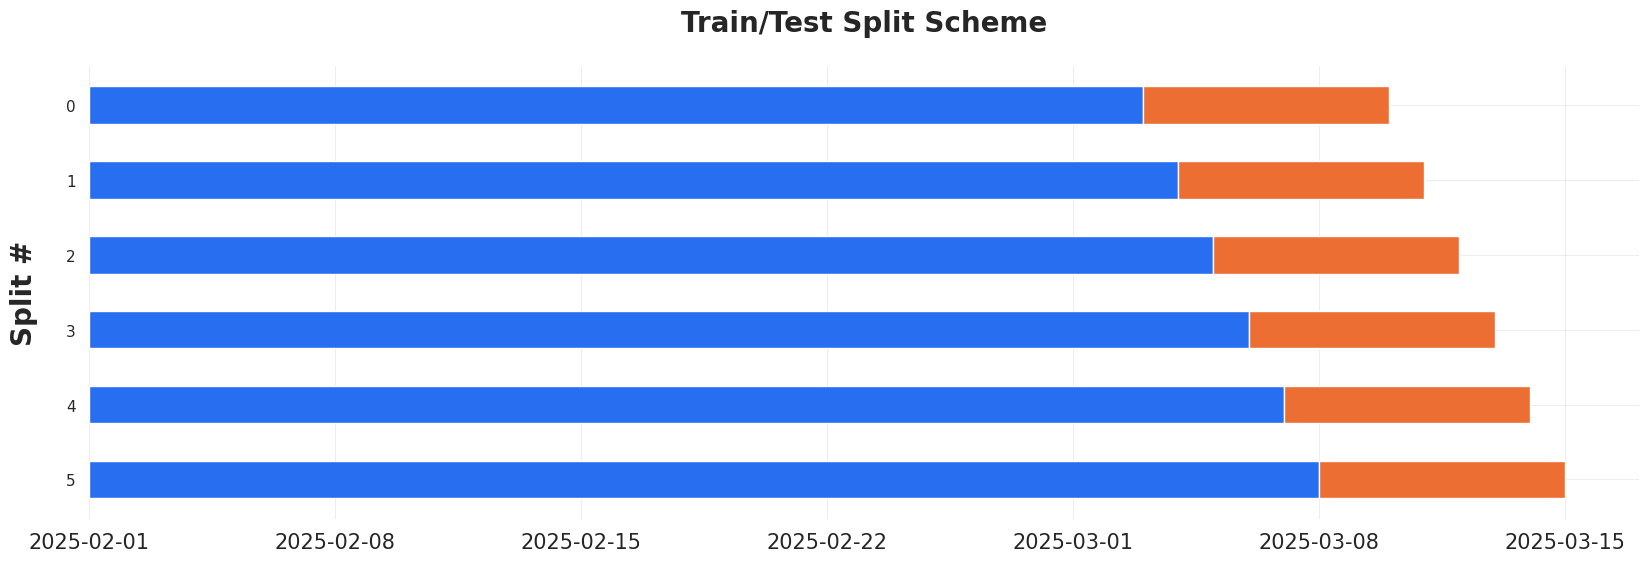

In [353]:
#expanding

bt_exp = BackTester(
    model=dlt, #наша моделька
    df=activity, #датафрейм для обучения
    min_train_len=24*30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)
bt_exp.plot_scheme()

In [354]:
bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,2.003781e-01,False
1,wmape,1.597353e-01,False
2,mape,1.693504e-01,False
3,mse,3.988827e+07,False
4,mae,4.762023e+03,False
5,rmsse,1.600387e+00,False


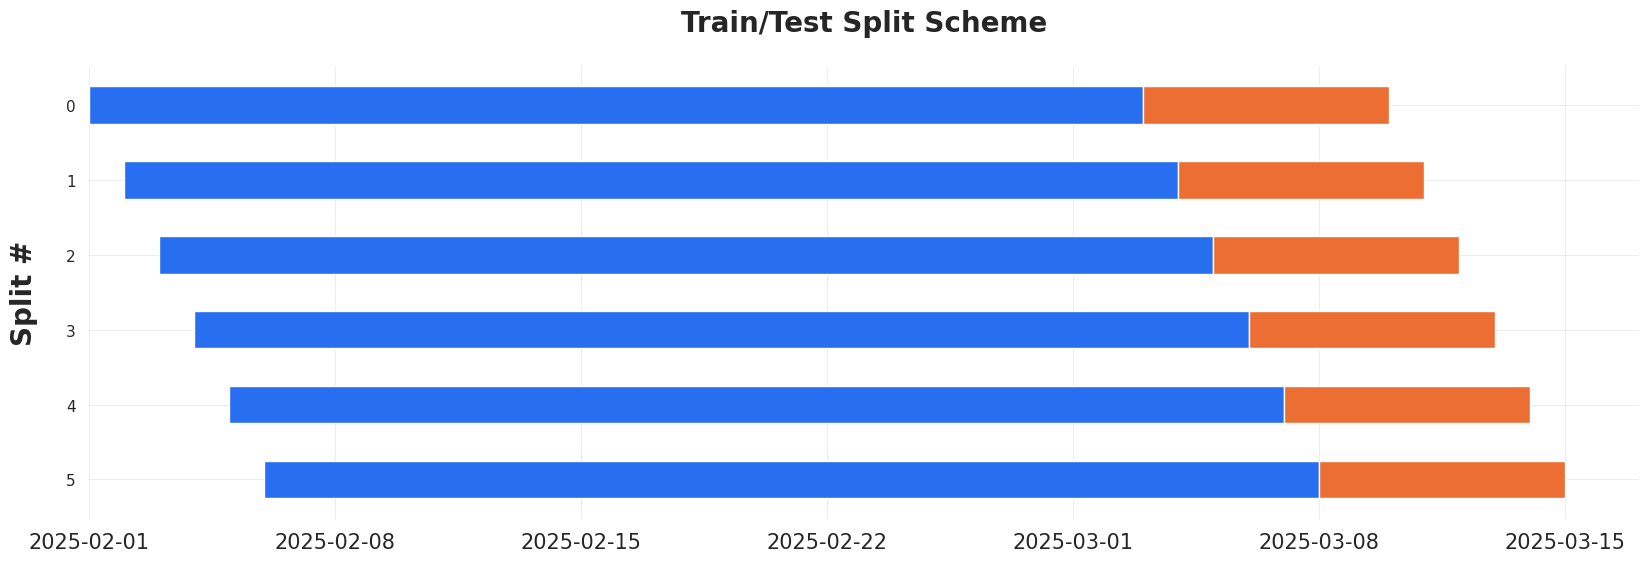

In [355]:
#rolling

bt_roll = BackTester(
    model=dlt,
    df=activity,
    min_train_len=24*30,
    incremental_len=24,
    forecast_len=24*7,
    window_type="rolling",
)
bt_roll.plot_scheme()

In [356]:
bt_roll.fit_predict() #обучаем
bt_roll.score()

,metric_name,metric_values,is_training_metric
0,smape,1.960859e-01,False
1,wmape,1.576587e-01,False
2,mape,1.668426e-01,False
3,mse,3.859849e+07,False
4,mae,4.700116e+03,False
5,rmsse,1.574300e+00,False


In [357]:
best_params, tuned_df = grid_search_orbit(param_grid={"damped_factor": np.arange(0.1, 1.0, 0.1)}, #наш параметр
                                        model=dlt,
                                        df=activity,
                                        min_train_len=24*30,
                                        incremental_len=24,
                                        forecast_len=24*7,
                                        metrics=None, #смотрим smape по умолчанию
                                        criteria="min", #говорим, что нам нужна минимизация
                                        verbose=True) #пусть печатает процесс выполнения

  0%|          | 0/9 [00:00<?, ?it/s]

2025-03-17 14:31:47 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1}
INFO:orbit:tuning hyper-params {'damped_factor': 0.1}
2025-03-17 14:31:47 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2025-03-17 14:31:52 - orbit - INFO - tuning metric:0.29054
INFO:orbit:tuning metric:0.29054
2025-03-17 14:31:52 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2}
INFO:orbit:tuning hyper-params {'damped_factor': 0.2}
2025-03-17 14:31:52 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2025-03-17 14:31:56 - orbit - INFO - tuning metric:0.29844
INFO:orbit:tuning metric:0.29844
2025-03-17 14:31:56 - orbit - INFO - tuning hyper-params {'damped_factor': 0.30000000000000004}
INFO:orbit:tuning hyper-params {'damped_factor': 0.30000000000000004}
2025-03-17 14:31:56 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) wit

In [358]:
best_params

[{'damped_factor': 0.9}]

In [359]:
params = dlt_mcmc.get_posterior_samples(permute=False) #достаём информацию о параметрах

params.keys() #их названия - можно залезть в оригинальный код на Stan, чтобы вычислить их значение

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

In [360]:
params["obs_sigma"].shape #лучше смотреть те, у которых третьего измерения либо нет, либо оно равно 1

(4, 750)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

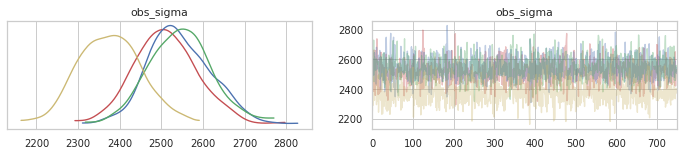

In [361]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

Регрессоры


Добавляю в качестве регроссора CTR и наличие флешмоба

In [362]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    countIf(action = 'like')/countIf(action = 'view') CTR,
    CASE 
    WHEN hour_time BETWEEN '2025-02-14' AND '2025-02-20' THEN 1
    ELSE 0
END AS flashmob
FROM 
    {db}.feed_actions
WHERE hour_time >= toDateTime('2025-02-01')
  AND hour_time <= toDateTime('2025-03-15')
GROUP BY hour_time
ORDER BY 
    hour_time
'''

In [363]:
regr_values = ph.read_clickhouse(query=query, connection=connection)
regr_values.head()

,hour_time,CTR,flashmob
0,2025-02-01 00:00:00,0.225492,0
1,2025-02-01 01:00:00,0.210429,0
2,2025-02-01 02:00:00,0.216842,0
3,2025-02-01 03:00:00,0.208710,0
4,2025-02-01 04:00:00,0.209122,0


In [364]:
#делаем общий датафрейм
data_reg = activity.merge(regr_values)
data_reg

,hour_time,views,CTR,flashmob
0,2025-02-01 00:00:00,15597,0.225492,0
1,2025-02-01 01:00:00,12983,0.210429,0
2,2025-02-01 02:00:00,9500,0.216842,0
3,2025-02-01 03:00:00,6751,0.208710,0
4,2025-02-01 04:00:00,6819,0.209122,0
...,...,...,...,...
1004,2025-03-14 20:00:00,35281,0.199172,0
1005,2025-03-14 21:00:00,35896,0.197682,0
1006,2025-03-14 22:00:00,34214,0.197258,0
1007,2025-03-14 23:00:00,30708,0.198189,0


In [365]:
data_reg.drop("hour_time", axis=1).corr() 

,views,CTR,flashmob
views,1.000000,-0.246769,0.414520
CTR,-0.246769,1.000000,0.158061
flashmob,0.414520,0.158061,1.000000


In [366]:
data_reg.drop("hour_time", axis=1).corr(method="spearman") 

,views,CTR,flashmob
views,1.000000,-0.279037,0.347201
CTR,-0.279037,1.000000,0.119568
flashmob,0.347201,0.119568,1.000000


Взяла для обучения 1 месяц и 2 недели для проверки предсказаний

In [367]:
train_dat = data_reg.query("hour_time < '2025-03-01 00:00:00'") #возьмём часть данных для обучения
test_dat = data_reg.query("hour_time >= '2025-03-01 00:00:00'").astype({"CTR":"int64"}) #а это будем предсказывать - важно сконвертировать в инт

In [368]:
train_dat

,hour_time,views,CTR,flashmob
0,2025-02-01 00:00:00,15597,0.225492,0
1,2025-02-01 01:00:00,12983,0.210429,0
2,2025-02-01 02:00:00,9500,0.216842,0
3,2025-02-01 03:00:00,6751,0.208710,0
4,2025-02-01 04:00:00,6819,0.209122,0
...,...,...,...,...
667,2025-02-28 19:00:00,41322,0.214898,0
668,2025-02-28 20:00:00,39652,0.213054,0
669,2025-02-28 21:00:00,37443,0.210240,0
670,2025-02-28 22:00:00,34534,0.199514,0


Смотрю на модели MAP

In [370]:
reg_model = DLT(response_col="views",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["CTR", "flashmob"] #наша колонка с регрессором! Должна быть списком
               ) 

reg_model.fit(train_dat)

2025-03-17 14:48:51 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


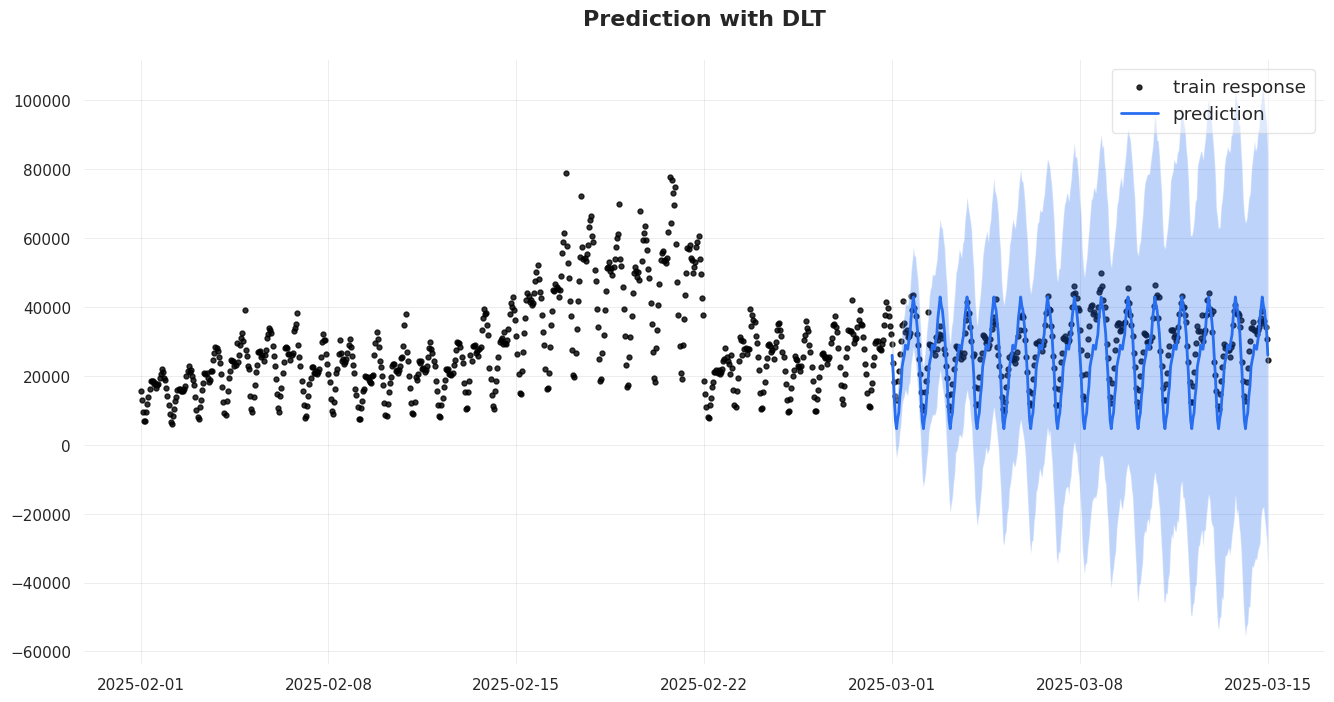

In [371]:
predicted_df_reg = reg_model.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_reg, "hour_time", 'views', title='Prediction with DLT') #так себе

In [372]:
predicted_df = reg_model.predict(df=test_dat, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-03-01 00:00:00,20746.632775,25953.431952,30958.884333,19721.082775,24927.881952,29933.334333,1025.55,1025.55,1025.55,0.0,0.0,0.0
1,2025-03-01 01:00:00,14162.315632,20553.557247,27167.953507,18536.615632,24927.857247,31542.253507,-4374.30,-4374.30,-4374.30,0.0,0.0,0.0
2,2025-03-01 02:00:00,6236.984641,13113.832542,19697.849766,18050.984641,24927.832542,31511.849766,-11814.00,-11814.00,-11814.00,0.0,0.0,0.0
3,2025-03-01 03:00:00,-572.103378,7095.107836,14559.182487,17260.596622,24927.807836,32391.882487,-17832.70,-17832.70,-17832.70,0.0,0.0,0.0
4,2025-03-01 04:00:00,-3668.617657,4642.583131,12359.745977,16616.582343,24927.783131,32644.945977,-20285.20,-20285.20,-20285.20,0.0,0.0,0.0


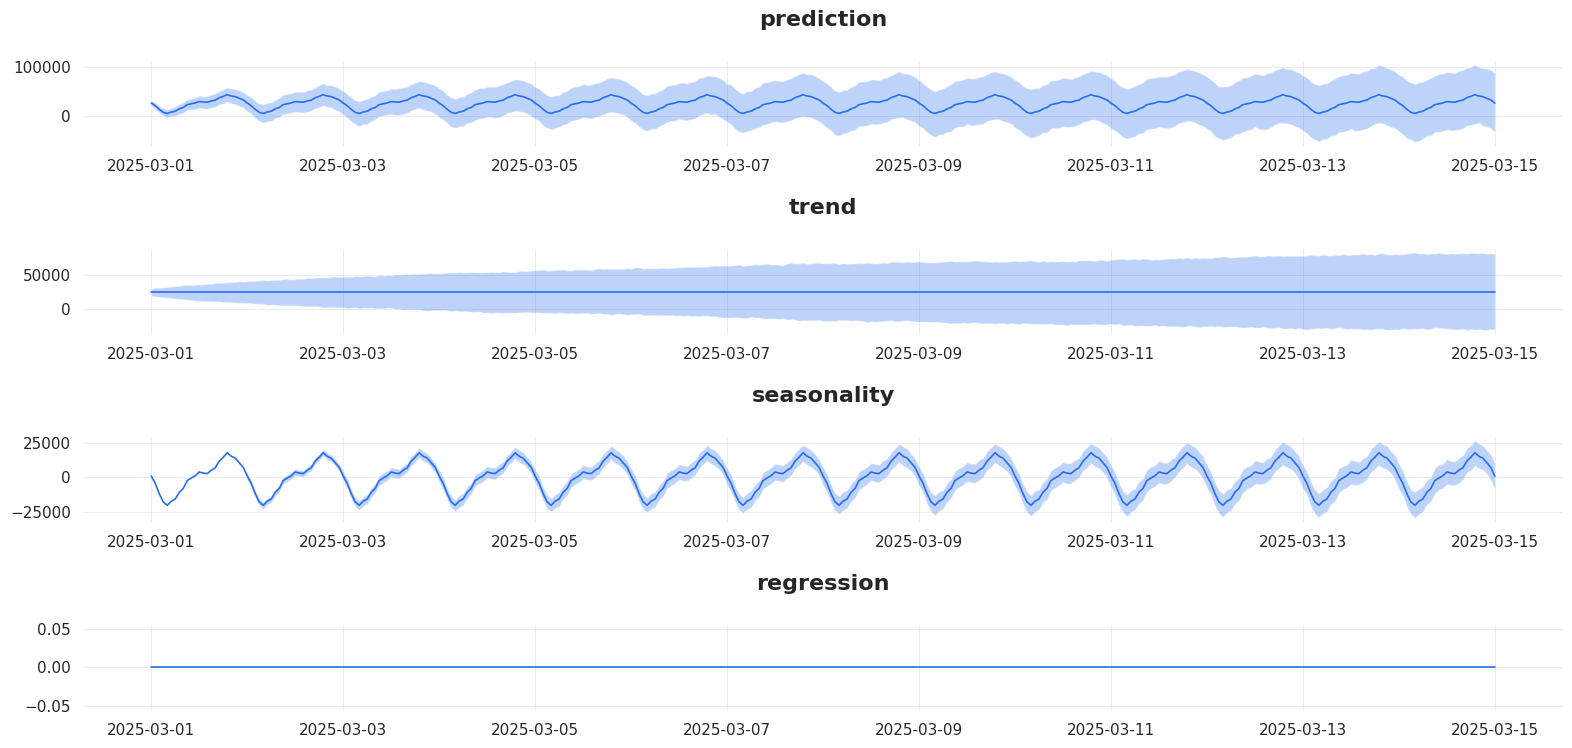

In [373]:
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality', "regression"])

In [289]:
reg_model.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,CTR,Regular,0.001434
1,hour,Regular,0.109535
2,flashmob,Regular,0.007849


априорные распределения

In [390]:
reg_model_prior = DLT(response_col="views",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["CTR", "flashmob"], 
                regressor_sign=["+","+"], #допустим, мы считаем, что связь обязательно положительная
                regressor_beta_prior=[0.3,0.5], #пусть мы думаем, что истинное значение коэффициента - вот такое
                regressor_sigma_prior=[0.1,0.1] #и зададим уровень уверенности
               ) 

reg_model_prior.fit(train_dat)

2025-03-17 14:58:45 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


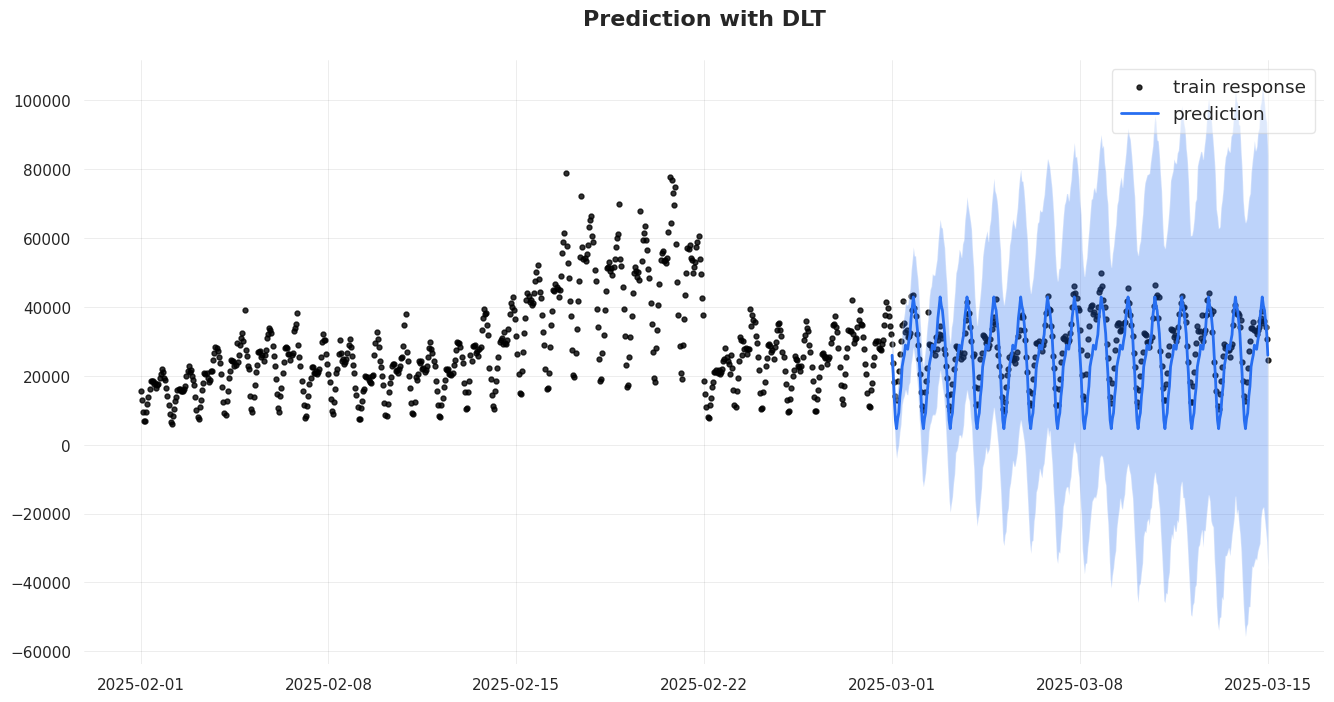

In [391]:
predicted_df_prior = reg_model_prior.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_prior, "hour_time", 'views', title='Prediction with DLT') #кажется, стало хуже

In [392]:
print(f"Модель с неинформативным априорным распределением: {reg_model.get_regression_coefs()['coefficient'][0]}")
print(f"Модель с информативным априорным распределением: {reg_model_prior.get_regression_coefs()['coefficient'][0]}")

Модель с неинформативным априорным распределением: -0.00184326
Модель с информативным априорным распределением: 0.299985


регуляризация

In [393]:
reg_model_auto = DLT(response_col="views",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["CTR", "flashmob"], 
                regression_penalty="auto_ridge"
               ) 

reg_model_auto.fit(train_dat)


2025-03-17 15:01:27 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


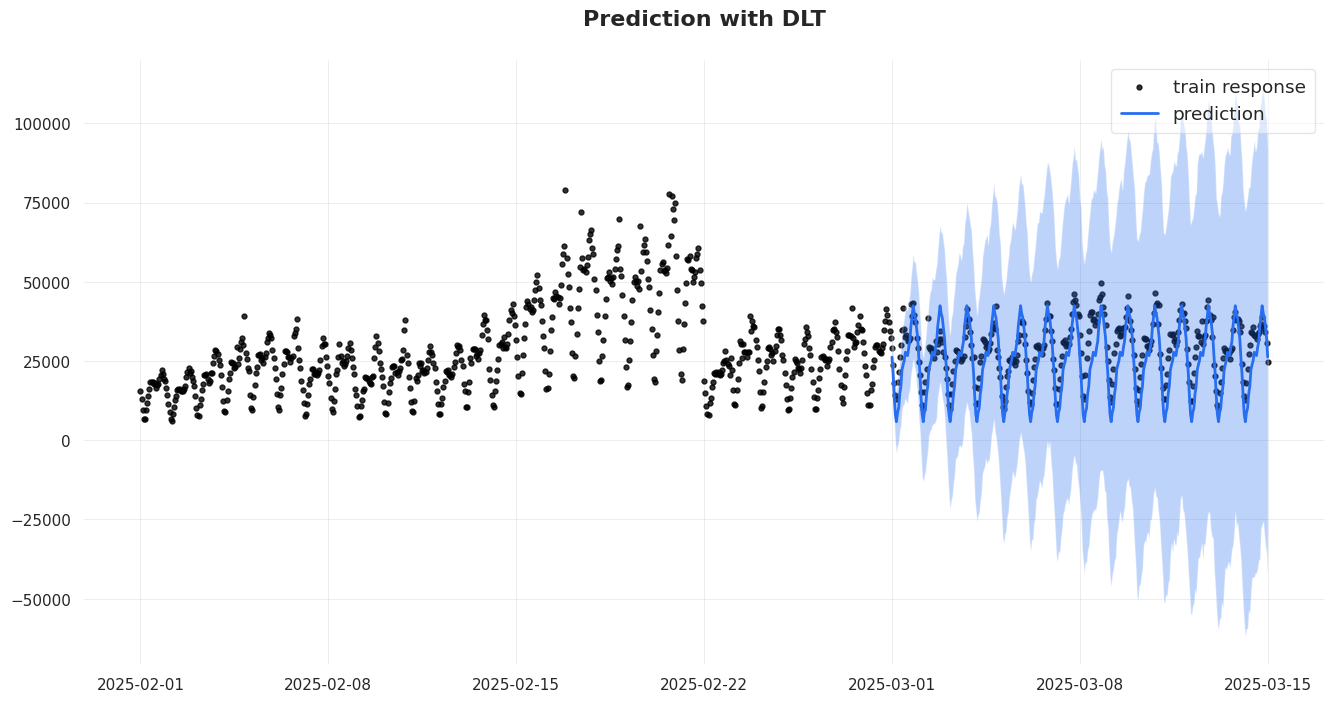

In [394]:
predicted_df_auto = reg_model_auto.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_auto, "hour_time", 'views', title='Prediction with DLT') 

In [397]:
reg_model_auto.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,CTR,Regular,0.0
1,flashmob,Regular,0.0


In [398]:
reg_model_lasso = DLT(response_col="views",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["CTR", "flashmob"], 
                regression_penalty="lasso"
               ) 

reg_model_lasso.fit(train_dat)

2025-03-17 15:02:19 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


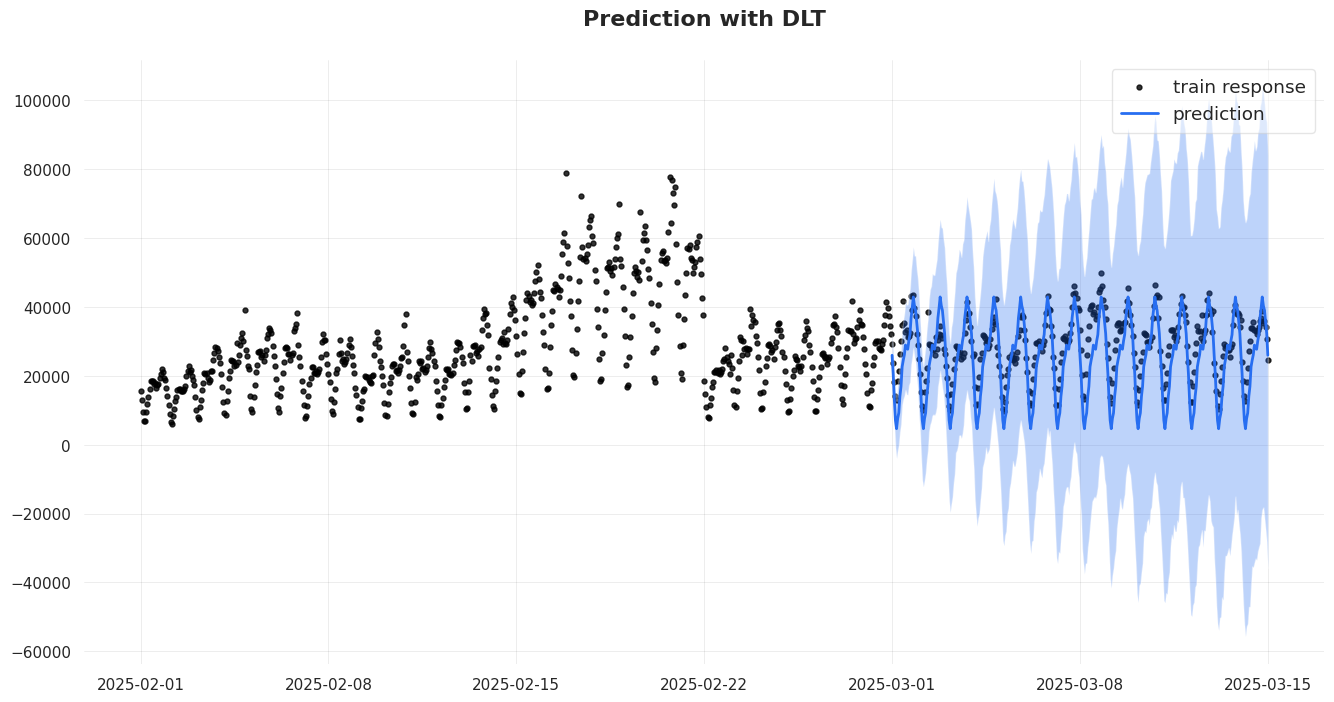

In [399]:
predicted_df_lasso = reg_model_lasso.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_lasso, "hour_time", 'views', title='Prediction with DLT') #кажется, стало хуже

In [400]:
reg_model_lasso.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,CTR,Regular,0.0
1,flashmob,Regular,0.0


информативные критерии

In [401]:
#для полноты обучим модель без регрессора, но на тех же данных

no_reg_model = DLT(response_col="views",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000
               ) 

no_reg_model.fit(train_dat)

2025-03-17 15:02:23 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


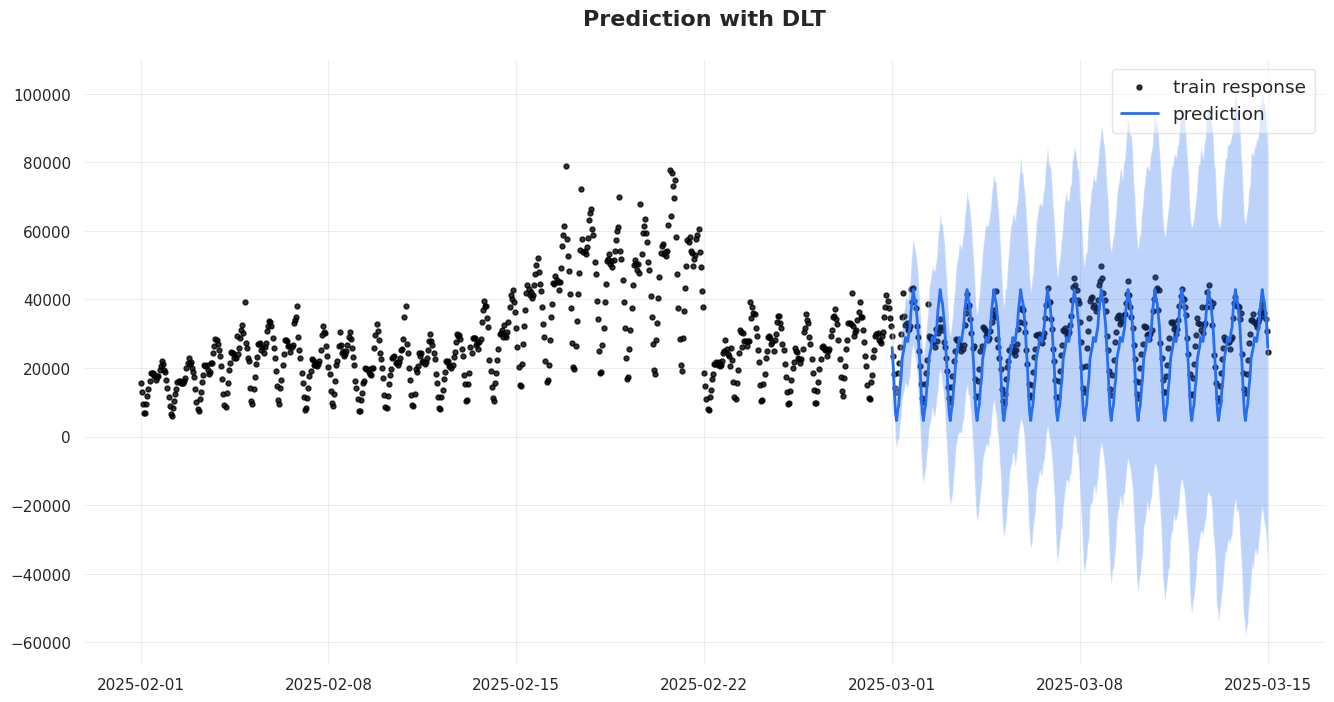

In [402]:
predicted_df = no_reg_model.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df, "hour_time", 'views', title='Prediction with DLT') 

In [403]:
print(f"Без регрессора: {no_reg_model.get_bic()}")
print(f"С регрессором: {reg_model.get_bic()}")
print(f"С информативным распределением: {reg_model_prior.get_bic()}")
print(f"С auto-ridge: {reg_model_auto.get_bic()}")
print(f"С lasso: {reg_model_lasso.get_bic()}")

Без регрессора: 12880.639649643661
С регрессором: 12887.149158780632
С информативным распределением: 12887.099178780632
С auto-ridge: 12912.761118780632
С lasso: 12887.147818780633


Самый низкий BIC у модели без регрессора

In [404]:
from orbit.diagnostics.metrics import rmsse
print(f"Без регрессора: {rmsse(test_dat.views.values, predicted_df.prediction.values, train_dat.views.values)}")
print(f"С регрессором: {rmsse(test_dat.views.values, predicted_df_reg.prediction.values, train_dat.views.values)}")
print(f"С информативным распределением: {rmsse(test_dat.views.values, predicted_df_prior.prediction.values, train_dat.views.values)}")
print(f"С auto-ridge: {rmsse(test_dat.views.values, predicted_df_auto.prediction.values, train_dat.views.values)}")
print(f"С lasso: {rmsse(test_dat.views.values, predicted_df_lasso.prediction.values, train_dat.views.values)}")

Без регрессора: 1.6162990672610371
С регрессором: 1.616198895059264
С информативным распределением: 1.6163012310818627
С auto-ridge: 1.5840664202341292
С lasso: 1.6164741572075012


Здесь же впереди модель с auto-ridge

Вопрос 3.Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.


На основе анализа результатов RMSSE, модель с auto-ridge кажется мне наиболее удачной, так как она показала наименьшую ошибку. Это значит, что auto-ridge лучше всего справляется с предотвращением переобучения и стабилизирует результаты предсказаний. Несмотря на тот факт, что коэффициенты регрессоров равны нулю. 
В итоге, регуляризация с auto-ridge оказалась более эффективной, чем другие модели.


Тот факт,что модель auto=range предотвращает переобучение за счет регуляризации, важен,потому что количество данных было ограничено.
Также у этой модели коэффициенты регрессоров равны 0,что может говорить о том,что на этом наборе данных модель без регрессоров работает лучше.


Ограничения: 
Значение метрики RMSE и BIC все равно большие,что может показывать неидеальность всех моделей. 
Также результаты могут измениться при изменении временноо промежутка.

Еще раз посмотрим модель auto-range:
Строю график с прогнозом на 30 дней без регрессоров, так как у них показало коэф 0

2025-03-17 15:25:32 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


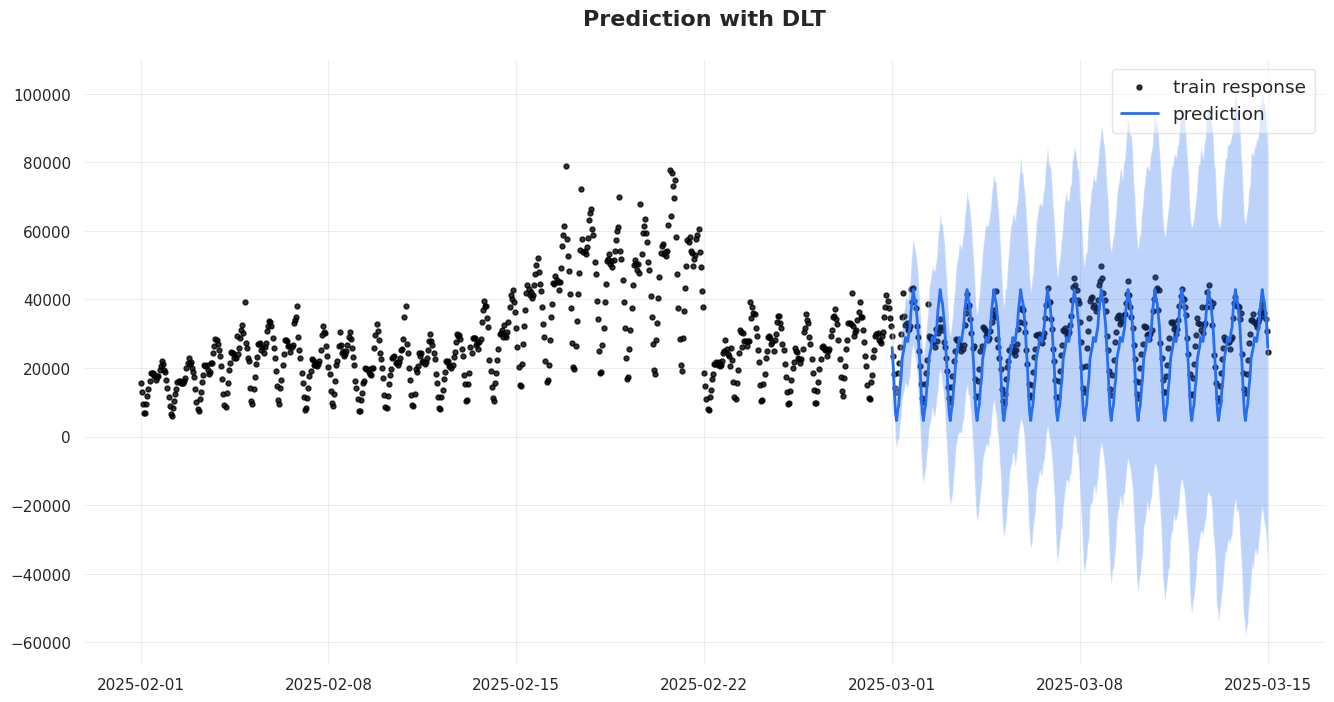

In [411]:
reg_model_auto = DLT(response_col="views",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regression_penalty="auto_ridge"
               ) 

reg_model_auto.fit(train_dat)

predicted_df_auto = reg_model_auto.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_auto, "hour_time", 'views', title='Prediction with DLT') 

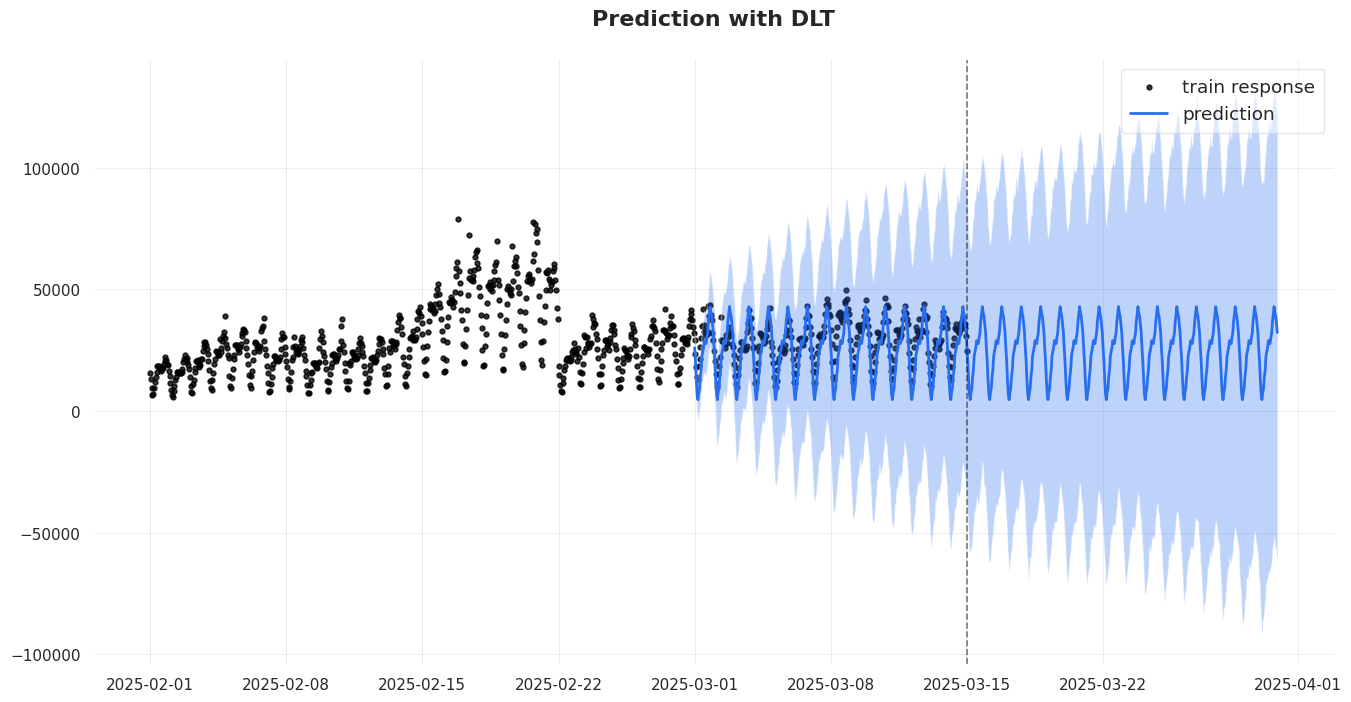

In [413]:

future_df = reg_model_auto.make_future_df(periods=24*30)

predicted_df = reg_model_auto.predict(df=future_df)

_ = plot_predicted_data(activity, predicted_df, "hour_time", 'views', title='Prediction with DLT')

Предсказание выглядит стабильным. У доверительного интервала больше идет разброс наверх,может быть это из-за увеличения количества просмотров в период флешмоба,поэтому модель рассматривает и такой исход событий

У orbit понравился широкий функционал,но не все настройки мне были понятны.